In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!pip install silence_tensorflow
!pip install pycm
!pip install lime
!pip install transformers
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

  Created wheel for silence-tensorflow: filename=silence_tensorflow-1.1.1-cp37-none-any.whl size=3743 sha256=597355cd1a1d720e3da28d4724764ea4449271722f84ba930d07115f65d4ac90
  Stored in directory: /root/.cache/pip/wheels/51/0b/35/cf3020764bee61daa81fa249df3a448e3806344a087fc12292
Successfully built silence-tensorflow
     |████████████████████████████████| 71kB 3.6MB/s 
     |████████████████████████████████| 573kB 7.4MB/s 
     |████████████████████████████████| 276kB 6.0MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=ab6aa1031a962d5558b45ed788cb626b6b4be4953ff73cde78631de6a7f13065
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime
     |████████████████████████████████| 1.9MB 4.2MB/s 
     |████████████████████████████████| 3.2MB 41.7MB/s 
     |████████████████████████████████| 890kB 26.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-

True

In [4]:
import os
default_path = "/content/gdrive/MyDrive/Colab Notebooks/Automatic Software Artifacts"
os.chdir(default_path)

In [5]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
## for deep learning
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
## for bert language model
import transformers
from transformers import BertTokenizer, TFBertModel, BertConfig, TFDistilBertModel
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv1D, GlobalMaxPooling1D, LSTM, SpatialDropout1D, Input, Flatten, MaxPooling1D
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing import text, sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import nltk
import re
## for bag-of-words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn import feature_selection
# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB
from sklearn.model_selection import StratifiedShuffleSplit
# Metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from pycm import *
## for explainer
from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api

import utils_functions as uf

import matplotlib as mpl
# Set the default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["b", "k", "c"]) 

np.random.seed(7)

### Some Utils Functions

In [6]:
# encode y_train
def encode_y(y_in):
    dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_in))}
    inverse_dic = {v:k for k,v in dic_y_mapping.items()}
    y_in = np.array([inverse_dic[y] for y in y_in])
    return y_in, dic_y_mapping

In [7]:
# '''
# Compute different text length metrics.
# :parameter
#     :param dtf: dataframe - dtf with a text column
#     :param column: string - name of column containing text
# :return
#     dtf: input dataframe with 2 new columns
# '''
def add_text_length(dtf, column):
    dtf['word_count'] = dtf[column].apply(lambda x: len(str(x).split(" ")))
    dtf['char_count'] = dtf[column].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
    dtf['sentence_count'] = dtf[column].apply(lambda x: len(str(x).split(".")))
    dtf['avg_word_length'] = dtf['char_count'] / dtf['word_count']
    dtf['avg_sentence_lenght'] = dtf['word_count'] / dtf['sentence_count']
    print(dtf[['word_count','char_count','sentence_count','avg_word_length','avg_sentence_lenght']].describe().T[["min","mean","max"]])
    return dtf

In [8]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling

def display_closestwords_tsnescatterplot(word_vect, dim, words):
    
    arr = np.empty((0,dim), dtype='f')
    word_labels = words

    # get close words
    #close_words = [model.similar_by_word(word) for word in words]
    
    # add the vector for each of the closest words to the array
    close_words=[]
    for word in words:
        arr = np.append(arr, np.array([word_vect[word]]), axis=0)
        close_words +=model.similar_by_word(word)
        
    for wrd_score in close_words:
        wrd_vector = word_vect[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    #np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()
    
def tsne_plot(word_vect, words):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    #for word in model.wv.vocab:
    for word in words:
        tokens.append(word_vect[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(14, 10)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

### Read and Show a Data Sample

In [9]:
file = 'dataset.csv'
df = pd.read_csv(file,encoding='ISO-8859-1')

labels = df.NumLabel
labels = labels.to_numpy()

In [10]:
df.sample(5)

,Label,NumLabel,Text,FileName
11,Design Document,0,place your ssl tls server keys and certificate...,../MSRDataset/Oracle/Design Document/2521-dock...
128,License,4,mit licenced copyright Ã¢ wisembly permission ...,../MSRDataset/Oracle/License/21787-elephant.io...
158,Contributors' Guide,5,running the tests you ll need npm https npmjs ...,../MSRDataset/Oracle/Contributors' Guide/15685...
98,License,4,the mit license copyright c automattic dev clo...,../MSRDataset/Oracle/License/21443-socket.io-n...
131,Contributors' Guide,5,angular js enterprise edition boilerplate this...,../MSRDataset/Oracle/Contributors' Guide/5371-...


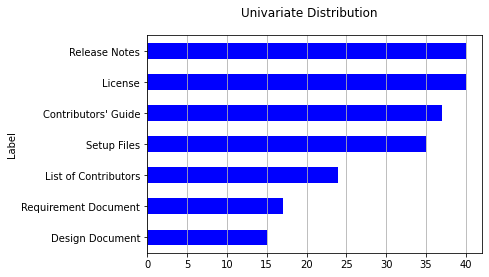

In [11]:
fig, ax = plt.subplots()
fig.suptitle("Univariate Distribution", fontsize=12)
df["Label"].reset_index().groupby("Label").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

### Run Preprocessing Function to Clean Text

In [12]:
# Load stopwords from NLTK
lst_stopwords = nltk.corpus.stopwords.words("english")
df["text_clean"] = df["Text"].apply(lambda x: 
                      uf.utils_preprocess_text(x, flg_stemm=True, flg_lemm=True, 
                      lst_stopwords=lst_stopwords))
df.sample(5)

,Label,NumLabel,Text,FileName,text_clean
31,List of Contributors,1,copyrightbegin copyright ericsson ab all right...,../MSRDataset/Oracle/List of Contributors/1544...,copyrightbegin copyright ericsson ab right res...
205,Release Notes,6,fixes fixed status code error on supervisord s...,../MSRDataset/Oracle/Release Notes/7215-dextr-...,fix fix statu code error supervisord superviso...
60,Setup Files,2,name device js version homepage https github c...,../MSRDataset/Oracle/Setup Files/23829-device....,name devic j version homepag http github com m...
30,List of Contributors,1,original authors niclas eklund contributors,../MSRDataset/Oracle/List of Contributors/1544...,origin author nicla eklund contributor
6,Design Document,0,mechanize forms span class docwarning this doc...,../MSRDataset/Oracle/Design Document/1641-mech...,mechan form span class docwarn document need r...


### Text Length Analysis

In [13]:
dtf = add_text_length(df, "text_clean")
dtf.head()

                      min         mean            max
word_count            3.0  1186.144231   40837.000000
char_count           16.0  5896.274038  206636.000000
sentence_count        1.0     1.000000       1.000000
avg_word_length       3.5     5.384789       7.153846
avg_sentence_lenght   3.0  1186.144231   40837.000000


,Label,NumLabel,Text,FileName,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght
0,Design Document,0,design operation and maintenance manual for me...,../MSRDataset/Oracle/Design Document/13663-cmg...,design oper mainten manual messagelogg message...,2485,14533,1,5.848290,2485.0
1,Design Document,0,gspread documentation master file created by s...,../MSRDataset/Oracle/Design Document/30200-gsp...,gspread document master file creat sphinx quic...,133,899,1,6.759398,133.0
2,Design Document,0,non blocking trace setting introduction before...,../MSRDataset/Oracle/Design Document/15549-otp...,non block trace set introduct otp trace set ch...,772,4302,1,5.572539,772.0
3,Design Document,0,layout doc title delite popup delite popup del...,../MSRDataset/Oracle/Design Document/12383-del...,layout doc titl delit popup delit popup delit ...,983,5086,1,5.173957,983.0
4,Design Document,0,design patterns observer,../MSRDataset/Oracle/Design Document/55544-des...,design pattern observ,3,19,1,6.333333,3.0


In [14]:
# encode y_train
def encode_y_train(y_train):
    dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_train))}
    inverse_dic = {v:k for k,v in dic_y_mapping.items()}
    y_train = np.array([inverse_dic[y] for y in y_train])
    return y_train, dic_y_mapping

In [15]:
from transformers import AutoModel, BertTokenizerFast

# import BERT-base pretrained model
# base_bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

## BERT
Transfer learning from a pre-trained of BERT:
24-layer, 1024-hidden, 16-heads, 336M parameters.
Trained on lower-cased English text.

### Tokenizer Definition

In [16]:
base_bert = 'bert-base-uncased' # Pick any desired pre-trained model

# Defining DistilBERT tokonizer
# tokenizer = BertTokenizer.from_pretrained(base_bert, do_lower_case=True, add_special_tokens=True,
#                                                 max_length=256, pad_to_max_length=True)

### Load Model

In [17]:
config = BertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False
transformer_model = TFBertModel.from_pretrained(base_bert, config = config)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


### Tokenization of Documents

In [27]:
def bert_tokenize(sentences, tokenizer):
    corpus = []
    sentences_list = []
    sentences_list = sentences.tolist()
#     for i in range(len(sentences_list)):
#         split_sentences = get_split(sentences_list[i])
#         corpus = corpus + split_sentences
#     print("Sentenças no Corpus:", len(corpus))
    input_ids, input_masks, input_segments = [],[],[]
#     for sentence in tqdm(sentences):
    for sentence in sentences_list:
#         print(sentence)
#         print(len(sentence.split()))
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=128, pad_to_max_length=True, 
                                             return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
#         print(input_ids)
#         print(len(input_ids[0]))
#     print(len(input_ids))
#         input_segments.append(inputs['token_type_ids'])        
        
#     return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32')

from tensorflow.keras.constraints import max_norm
def fit_bert_classif(X_train, y_train, X_test, encode_y=False, dic_y_mapping=None, model=None, epochs=1, batch_size=8):
    ## encode y
    if encode_y is True:
        dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_train))}
        inverse_dic = {v:k for k,v in dic_y_mapping.items()}
        y_train = np.array( [inverse_dic[y] for y in y_train] )
    # print(dic_y_mapping)
    
    ## model
    if model is None:
        ### inputs
        input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
        input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32')
#         input_segments_in = tf.keras.layers.Input(shape=(128,), name='segment_token', dtype='int32') 

        
        ### pre-trained bert
        X = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]
    
        ### fine-tuning
        # 2 layers of bidirectional lstm
        X = layers.Bidirectional(layers.LSTM(180, dropout=0.0,
                              return_sequences=True))(X)
        X = layers.Bidirectional(layers.LSTM(90, dropout=0.0))(X)

        # ## final dense layers
        X = layers.Dense(32, activation='tanh', kernel_constraint=max_norm(11))(X)
        # X = layers.Dropout(0.1)(X)

        y_out = layers.Dense(len(np.unique(y_train)), activation='softmax')(X)


        ### compile
        model = Model(inputs=[input_ids_in, input_masks_in], outputs = y_out)

        for layer in model.layers[:3]:
            layer.trainable = False

        model.compile(loss='sparse_categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
        # print(model.summary())
        
    ## train
    verbose = 1 if epochs > 1 else 2
    training = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, shuffle=True, verbose=verbose, validation_split=0.2)
    if epochs > 1:
        utils_plot_keras_training(training)
    
    ## test
    predicted_prob = model.predict(X_test)
    predicted = [dic_y_mapping[np.argmax(pred)] for pred in predicted_prob] if encode_y is True else [np.argmax(pred)]
    return training.model, predicted_prob, predicted


'''
Plot loss and metrics of keras training.
'''
def utils_plot_keras_training(training):
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
    
    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()
    
    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()

### Define Target

In [21]:
X = df["Text"]
y = df["Label"].values

In [20]:
# Split original sentence in small sentences.
def get_split(text1):
    l_total   = []
    l_partial = []
    len_final = 0
    if len(text1.split())//150 > 0:
        n = len(text1.split())//150
    else:
        n = 1
    for w in range(n):
        if w == 0:
            l_partial = text1.split()[:200]
            l_total.append(" ".join(l_partial))
            len_final = len_final+ (len(l_total[w].split()))
        else:
            l_partial = text1.split()[w*150:w*150+200]
            l_total.append(" ".join(l_partial))
            len_final = len_final+ (len(l_total[w].split()))
        if (w == n-1 and n != 1) and (len_final-50 < len(text1.split())):
            l_partial = text1.split()[n*200-50:len(text1.split())]
            l_total.append(" ".join(l_partial))
    return l_total

In [22]:
# Function to replicate the same number of targets (classes) for each feature that is added.
novas_features = []
idx = 0
total_geral = 0
for i, val in X.iteritems():
    total = get_split(X[i]) # divides long sentences into smaller sentences
    novas_features = novas_features + total
    if len(X[i].split()) > 200:
        total_geral = total_geral + len(total)
        for j in range(len(total)-1):
            y = np.insert(y, idx, y[idx])
            idx += 1
    idx += 1
print(f'Summary - Initial Samples: {len (df ["Label"].values)} | Total New Samples: {len (y)}')

X = pd.Series(novas_features)

Summary - Initial Samples: 208 | Total New Samples: 2315


### Plot data


In [23]:
df_target = pd.DataFrame(y, columns=['Label'])
df_data = pd.concat([X,df_target], axis=1)

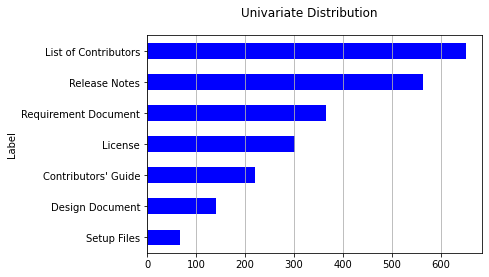

In [24]:
fig, ax = plt.subplots()
fig.suptitle("Univariate Distribution", fontsize=12)
df_data["Label"].reset_index().groupby("Label").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

### Training and Fine-tuning

Epoch 1/2
186/186 [==============================] - 75s 315ms/step - loss: 0.9471 - accuracy: 0.6690 - val_loss: 0.6000 - val_accuracy: 0.7951
Epoch 2/2
186/186 [==============================] - 56s 301ms/step - loss: 0.4597 - accuracy: 0.8280 - val_loss: 1.3750 - val_accuracy: 0.5660


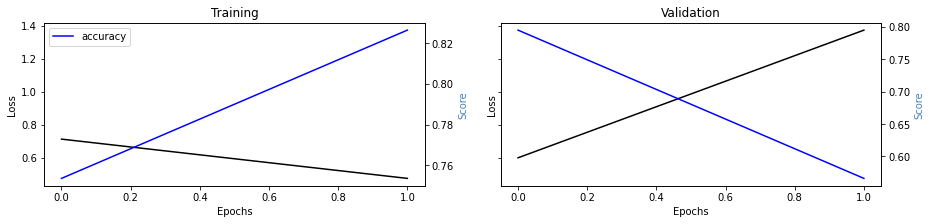


--------------------------------------------------------------------
Iteração: 1 Fold: 1 Accuracy: 0.5356371490280778, Mean Accuracy: 0.5356371490280778

--------------------------------------------------------------------
Epoch 1/2
186/186 [==============================] - 74s 315ms/step - loss: 0.9594 - accuracy: 0.6692 - val_loss: 0.5882 - val_accuracy: 0.7790
Epoch 2/2
186/186 [==============================] - 56s 300ms/step - loss: 0.4438 - accuracy: 0.8368 - val_loss: 0.3655 - val_accuracy: 0.8679


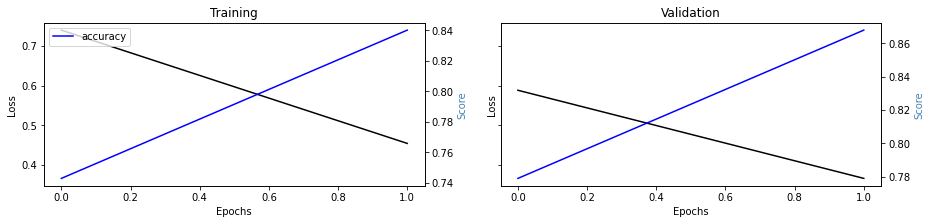


--------------------------------------------------------------------
Iteração: 1 Fold: 2 Accuracy: 0.8790496760259179, Mean Accuracy: 0.7073434125269978

--------------------------------------------------------------------


In [28]:
final_mean = []
conf_matrix_list_of_arrays = []
for i in range(1):

    accrs = []
    fold=0
#     conf_matrix_list_of_arrays = []

    k=2
    sss = StratifiedShuffleSplit(n_splits=k, test_size=0.2, random_state=42)

    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        fold +=1

        #create tensors
        X_train = bert_tokenize(sentences=X_train, tokenizer=tokenizer)
        X_test = bert_tokenize(sentences=X_test, tokenizer=tokenizer)

        model, predicted_prob, predicted = fit_bert_classif(X_train, y_train, X_test, encode_y=True, 
                                                            model=None, epochs=2, batch_size=8)
        # Validade Test Set
        accr = metrics.accuracy_score(y_test, predicted)
        #
        conf_matrix = confusion_matrix(y_test, predicted)
        conf_matrix_list_of_arrays.append(conf_matrix)
        #
        accrs.append(accr)

        print('\n--------------------------------------------------------------------')
        print(f'Iteração: {i+1} Fold: {fold} Accuracy: {accr}, Mean Accuracy: {sum(accrs)/fold}')
        print('\n--------------------------------------------------------------------')
    final_mean.append(sum(accrs)/k)

# means for Confusion Matrix
mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)

                                          Metrics Resume                                          
Class Name          	 Precision	    Recall	  F1-Score	       MCC	       AUC
Contributors' Guide 	      0.62	      0.35	      0.44	      0.42	      0.66
Design Document     	      0.75	      0.43	      0.55	      0.55	      0.71
License             	      0.91	       1.0	      0.95	      0.95	      0.99
List of Contributors	      0.98	       0.9	      0.94	      0.92	      0.95
Release Notes       	      0.96	      0.47	      0.63	      0.62	      0.73
Requirement Document	      0.36	      0.81	       0.5	      0.41	      0.77
Setup Files         	      0.79	      0.79	      0.79	      0.78	      0.89

Macro Average       	      0.77	      0.68	      0.68	      0.66	      0.81
Micro Average       	      0.71	      0.71	      0.71	      0.78	      0.83


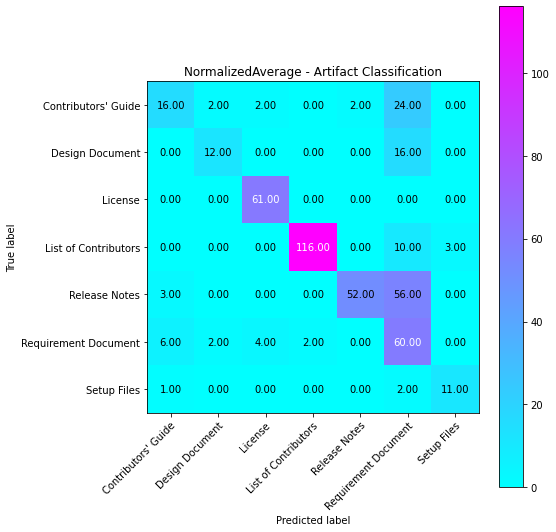

In [29]:
uf.custom_metrics(mean_of_conf_matrix_arrays, np.unique(y_test))

Plot ROC Curve

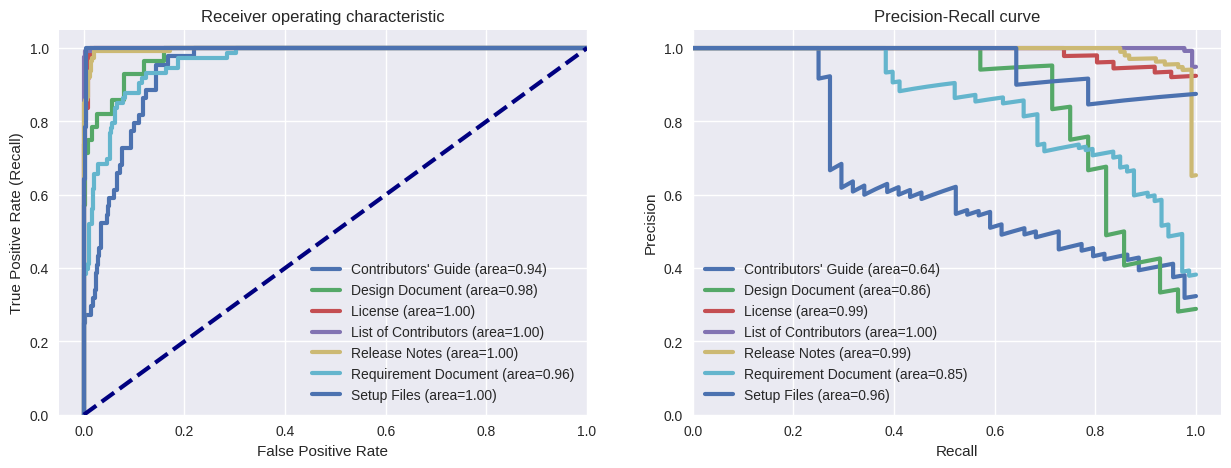

In [78]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

import matplotlib as mpl
mpl.style.use('seaborn')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

### BERT with Conventional ML

In [ ]:
def utils_bert_embedding(txt, tokenizer, nlp, log=False):
    idx = tokenizer.encode(txt, add_special_tokens=True, max_length=256, pad_to_max_length=True, 
                                             return_attention_mask=True, return_token_type_ids=True)
    print(idx)
    if log is True:
        print("tokens:", tokenizer.convert_ids_to_tokens(idx))
        print("ids   :", tokenizer.encode(txt))
    idx = np.array(idx)[None,:]
    embedding = nlp(idx)
    X = np.array(embedding[0][0][1:-1])
    return X
'''
Creates a feature matrix (num_docs x vector_size)
:parameter
    :param x: string or list
    :param tokenizer: transformers tokenizer
    :param nlp: transformers bert
    :param log: bool - print tokens
:return
    vector or matrix 
'''
def embedding_bert(x, tokenizer=None, nlp=None, log=False):
    tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased') if tokenizer is None else tokenizer
    nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased') if nlp is None else nlp
    
    ## single word --> vec (size,)
    if (type(x) is str) and (len(x.split()) == 1):
        X = utils_bert_embedding(x, tokenizer, nlp, log).reshape(-1)
    
    ## list of words --> matrix (n, size)
    elif (type(x) is list) and (type(x[0]) is str) and (len(x[0].split()) == 1):
        X = utils_bert_embedding(x, tokenizer, nlp, log)
    
    ## list of lists of words --> matrix (n mean vectors, size)
    elif (type(x) is list) and (type(x[0]) is list):
        lst_mean_vecs = [utils_bert_embedding(lst, tokenizer, nlp, log).mean(0) for lst in x]
        X = np.array(lst_mean_vecs)
    
    ## single text --> matrix (n words, size)
    elif (type(x) is str) and (len(x.split()) > 1):
        X = utils_bert_embedding(x, tokenizer, nlp, log)
        
    ## list of texts --> matrix (n mean vectors, size)
    else:
        lst_mean_vecs = [utils_bert_embedding(txt, tokenizer, nlp, log).mean(0) for txt in x]
        X = np.array(lst_mean_vecs)
    return X

In [ ]:
# Use for mNB
from sklearn.preprocessing import MinMaxScaler, normalize
def normalizer(X):
    scaler = MinMaxScaler()
    scaled_X = scaler.fit_transform(X)
    normalized_X = normalize(scaled_X, norm='max', axis=0, copy=True)
    return(normalized_X)

#### Classifier

In [ ]:
# Model Design
clf1 = svm.SVC(gamma='scale')
clf2 = RandomForestClassifier(n_estimators=500, random_state=1)
clf3 = MultinomialNB(alpha=0.01)
clf4 = DecisionTreeClassifier(random_state=0, max_depth=500)

svc = SVC(probability=True, kernel='linear')
ada = AdaBoostClassifier(n_estimators=50, base_estimator=svc,learning_rate=1)
ada2 = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=600,
    learning_rate=1.5,
    algorithm="SAMME")
ada3 = AdaBoostClassifier()
rf = RandomForestClassifier(max_depth=100, n_estimators=100, max_features=10)
# nb = naive_bayes.MultinomialNB(alpha=0.01)
nb = naive_bayes.MultinomialNB(alpha=0.0)
lr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', class_weight='balanced', C=1500)
dt = DecisionTreeClassifier(max_depth=500)

In [ ]:
# Disable bert warnings
import logging
logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)
from tqdm import tqdm
accrs = []
preds = []
conf_matrix_list_of_arrays = []
fold = 0
k=10

sss = StratifiedShuffleSplit(n_splits=k, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    fold +=1

    X_train = embedding_bert(X_train,tokenizer, transformer_model, log=False)
    X_train = normalizer(X_train) # Use for mNB
    X_test = embedding_bert(X_test,tokenizer, transformer_model, log=False)
    X_test = normalizer(X_test) # Use for mNB
    
    dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_train))}

    # train classifier
    model = nb.fit(X_train, y_train)
    
    # test
    predicted_prob = model.predict_proba(X_test)
    predicted = [dic_y_mapping[np.argmax(pred)] for pred in predicted_prob]
    
    # Validade Test Set
    accr = metrics.accuracy_score(y_test, predicted)

    conf_matrix = confusion_matrix(y_test, predicted)
    conf_matrix_list_of_arrays.append(conf_matrix)

    accrs.append(accr)
    print('\n--------------------------------------------------------------------')
    print(f'Fold: {fold} Accuracy: {accr}, Mean Accuracy: {sum(accrs)/fold}')
    print('--------------------------------------------------------------------')
    

# means for Confusion Matrix
mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)

### Plot Metrics Resume and Confusion Matrix

In [ ]:
uf.custom_metrics(mean_of_conf_matrix_arrays, np.unique(y_test))

### Voting Classifier

In [ ]:
accrs = []
conf_matrix_list_of_arrays = []
kfolds=10
fold = 0
sss = StratifiedShuffleSplit(n_splits=kfolds, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    fold +=1

    X_train = embedding_bert(X_train,tokenizer, transformer_model, log=False)
    X_train = normalizer(X_train) # Use for mNB
    X_test = embedding_bert(X_test,tokenizer, transformer_model, log=False)
    X_test = normalizer(X_test) # Use for mNB
    
    dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_train))}
    
    model = VotingClassifier(estimators=[
        ('svm', clf1),('rf', clf2), ('mnb', clf3), ('tree', clf4)], voting='hard',weights=[1,1,2,1])
    model = model.fit(X_train, y_train)
    
    predicted = model.predict(X_test)
    accr = metrics.accuracy_score(y_test, predicted)
    #
    conf_matrix = confusion_matrix(y_test, predicted)
    conf_matrix_list_of_arrays .append(conf_matrix)
    #    
    accrs.append(accr)
#     print(metrics.classification_report(y_test, predicted))

    print(f'Fold: {fold} Accuracy: {accr}, Mean Accuracy: {sum(accrs)/fold}')

# means for Confusion Matrix
mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)

### Plot Metrics Resume and Confusion Matrix

In [ ]:
uf.custom_metrics(mean_of_conf_matrix_arrays, np.unique(y_test))